<a href="https://colab.research.google.com/github/FrancescoMonaco/LFN_Project/blob/francesco_branch/LFN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Data Retrieval


In [1]:
!pip install nilearn
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 66.1 MB/s eta 0:00:00


In [36]:
from nilearn import datasets, plotting
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import gc

In [4]:
#@title Data downloads

# Load the brain atlas
atlas = datasets.fetch_atlas_msdl()
# Load the atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Load atlas data stored in 'labels'
labels = atlas["labels"]

# Load the dataset
_, urls = datasets.fetch_ds000030_urls()

exclusion_patterns = [
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-rest*",
    "*task-scap*",
    "*task-task*",
]
urls = datasets.select_from_index(
    urls, exclusion_filters=exclusion_patterns, n_subjects=1
)

data_dir, _ = datasets.fetch_openneuro_dataset(urls=urls)

 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 102293504 of 102374780 bytes (99.9%,    0.0s remaining) ...done. (2 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 105250816 of 120927302 bytes (87.0%,    0.4s remaining) ...done. (4 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 55009731 bytes (97.1%,    0.0s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 55877632 of 59250229 bytes (94.3%,    0.1s remaining) ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 37683200 of 40353955 bytes (93.4%,    0.1s remaining) ...done. (2 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 5685248 of 46149990 bytes (12.3%,    7.2s remaining) ...done. (2 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


In [ ]:
#@title Const variables for data retrieval
base_path = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/"

# MRI to Graph

In [31]:
from nilearn.maskers import NiftiMapsMasker

masker = NiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# Define the path to the TSV file
tsv_file = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_desc-confounds_regressors.tsv"

# Load the TSV file into a DataFrame and remove invalid values
confounds_data = pd.read_csv(tsv_file, sep='\t')
confounds_data = confounds_data.replace([np.nan, np.inf, -np.inf], 0)

func_filename = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
time_series = masker.fit_transform(func_filename, confounds=confounds_data)


[NiftiMapsMasker.wrapped] loading regions from None
Resampling maps
[Memory]0.2s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7fec2c03dae0>, { 'allow_overlap': True,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': None,
  'maps_img': '/root/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': 'zscore_sample',
  'standardize_confound

[GraphicalLassoCV] Done refinement  1 out of 4:   3s
[GraphicalLassoCV] Done refinement  2 out of 4:  13s
[GraphicalLassoCV] Done refinement  3 out of 4:  26s
[GraphicalLassoCV] Done refinement  4 out of 4:  40s


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:233: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning:

graphical_lasso: did not converge after 100 iteration: dual gap: -1.820e-03



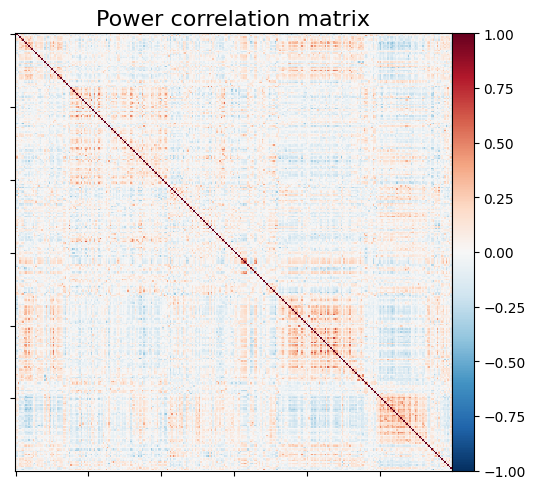

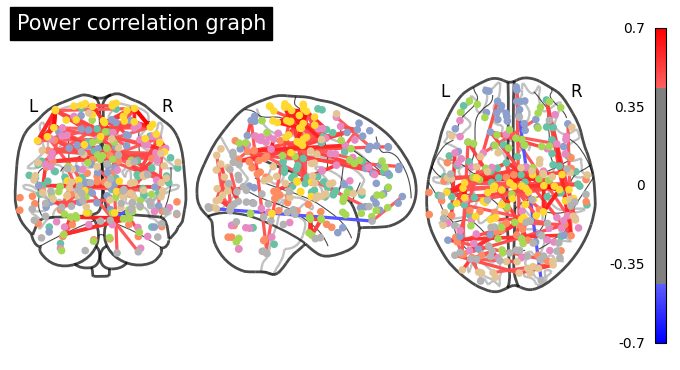

In [32]:
from nilearn.maskers import NiftiSpheresMasker

power = datasets.fetch_coords_seitzman_2018(legacy_format=False)
coords = np.vstack((power.rois["x"], power.rois["y"], power.rois["z"])).T
spheres_masker = NiftiSpheresMasker(
    seeds=coords,
    smoothing_fwhm=6,
    radius=3.0,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
)

timeseries = spheres_masker.fit_transform(
    func_filename, confounds=confounds_data
)

try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

covariance_estimator = GraphicalLassoCV(cv=3, verbose=1)

covariance_estimator.fit(timeseries)
matrix = covariance_estimator.covariance_
plotting.plot_matrix(
    matrix,
    vmin=-1.0,
    vmax=1.0,
    colorbar=True,
    title="Power correlation matrix",
)

# Tweak edge_threshold to keep only the strongest connections.
plotting.plot_connectome(
    matrix,
    coords,
    title="Power correlation graph",
    edge_threshold="99.8%",
    node_size=20,
    colorbar=True,
)

In [33]:
threshold = 0.2 # @param {type:"slider", min:0, max:1, step:0.05}
power_correlation_matrix = matrix
G = nx.Graph()
n = power_correlation_matrix.shape[0]  # Number of brain regions

for i in range(n):
    for j in range(i + 1, n):
        if power_correlation_matrix[i, j] >= threshold:
            G.add_edge(i, j)


In [34]:
pos = nx.spring_layout(G)
node_degrees = dict(G.degree())


# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure with size proportional to degree
for node, (x, y) in pos.items():
    fig.add_trace(go.Scatter(x=[x], y=[y], mode="markers", marker=dict(size=2 * node_degrees[node], opacity=0.7), name=str(node)))

# Add edges to the figure
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1)))

# Customize the figure further as needed

# Show the interactive plot
fig.show()


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(node_degrees.values()) / num_nodes

# Print the results
print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Average Degree:", average_degree)

Number of Nodes: 285
Number of Edges: 1485
Average Degree: 10.421052631578947


In [37]:
gc.collect()

9735